# Wrangling network data into workable format

In [1]:
import datetime

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style='darkgrid', font_scale=1.2)

## Office

Dataset of office interactions. See [source](http://www.sociopatterns.org/datasets/contacts-in-a-workplace/).

In [2]:
# Import temporal edge data — (t, i, j) format
with open('./data_sources/office/tij_InVS.dat', 'r') as f:
    tij = [tuple(map(int, l.rstrip('\n').split())) for l in f.readlines()]

assert len(tij) == 9827

tij[:10]

[(28820, 492, 938),
 (28860, 267, 272),
 (29300, 181, 826),
 (29780, 79, 181),
 (30000, 150, 196),
 (30020, 21, 150),
 (30060, 21, 205),
 (30060, 21, 150),
 (30060, 448, 826),
 (30060, 765, 826)]

In [3]:
# Import node data
with open('./data_sources/office/metadata_InVS13.txt', 'r') as f :
    meta = [tuple(l.rstrip('\n').split()) for l in f.readlines()]
    meta = [(int(n), d) for (n, d) in meta]

meta[:10]

[(35, 'DISQ'),
 (184, 'DISQ'),
 (751, 'DISQ'),
 (255, 'DISQ'),
 (131, 'DISQ'),
 (273, 'DISQ'),
 (743, 'DISQ'),
 (210, 'DISQ'),
 (826, 'DISQ'),
 (265, 'DISQ')]

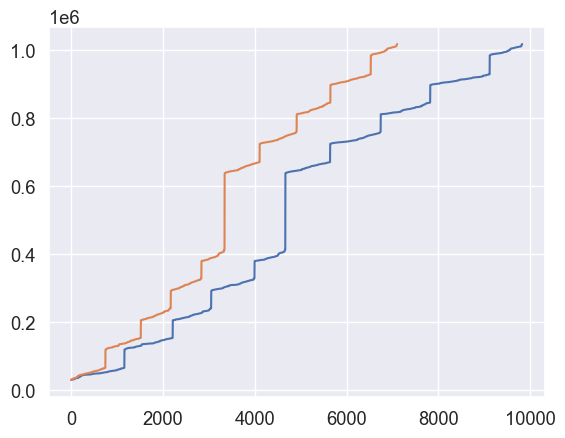

In [4]:
people = list(zip(*meta))[0]

tstamps = list(list(zip(*tij))[0])                  # list of timestamps
tstamps_unique = sorted(set(list(zip(*tij))[0]))    # list of unique timestamps

plt.plot(tstamps)
plt.plot(tstamps_unique)

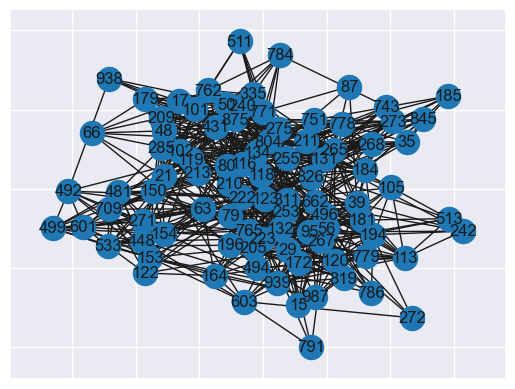

In [5]:
# Construct static office graph
office = nx.Graph()

office.add_nodes_from(people)

for t, i, j in tij :
    office.add_edge(i, j)
    office[i][j].setdefault('t', []).append(t)

nx.draw_networkx(office)

In [6]:
# Ensure generation procedure preserves all timestamps
ts = sorted([t for e in office.edges.data('t') for t in e[2]])
assert ts == tstamps

In [7]:
# Save network to disk
nx.write_edgelist(office, './networks/office.txt')

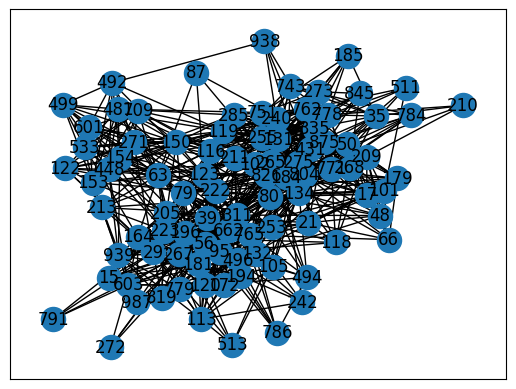

In [9]:
# Ensure save preserves network
H = nx.read_edgelist('./networks/office.txt')
nx.draw_networkx(H)
assert nx.is_isomorphic(office, H)

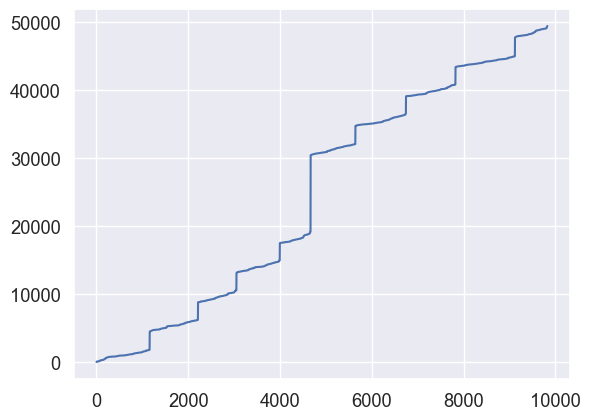

In [7]:
# Convert timestamps to timepoints
office_pts = nx.read_edgelist('./networks/office.txt')

t_res = 20  # Resolution in seconds
start = tstamps_unique[0]
to_tpoint = lambda tstamp : int((tstamp-start) / t_res)
# t_res_map = [to_tpoint(t) for t in tstamps_unique]

office_pts.edges(data=True)

for u, v in office_pts.edges() :
    office_pts[u][v]['t'] = [to_tpoint(t) for t in office_pts[u][v]['t']]

# office_pts.edges(data=True)

tpoints = sorted([t for d in list(zip(*list(office_pts.edges(data=True))))[2] for t in d['t']])
plt.plot(tpoints)

In [11]:
# Save network as to disk
nx.write_edgelist(office_pts, './networks/office_pts.txt')

In [13]:
print("Quick stats")
print(f"# nodes  : {office_pts.number_of_nodes()}")
print(f"# edges  : {office_pts.number_of_edges()}")
print(f"# events : {len(tij)}")

Quick stats
# nodes  : 92
# edges  : 755
# events : 9827


## Online social network

Dataset of social interactions in an online social network at UCI. See [source](https://toreopsahl.com/datasets/#online_social_network).

In [8]:
# Import temporal edge data — (t, i, j) format
with open('./data_sources/social/OCnodeslinks.txt', 'r') as f :
    social_tij = []
    for l in f.readlines() :
        t, i, j, _ = l.rsplit(maxsplit=3)
        t = datetime.datetime.strptime(t.strip("\""), '%Y-%m-%d %H:%M:%S')  # Convert string time to Python datetime objects
        social_tij.append((t, int(i), int(j)))

social_tij[:10]

[(datetime.datetime(2004, 3, 23, 20, 11, 55), 3, 3),
 (datetime.datetime(2004, 3, 23, 20, 12, 20), 1, 1),
 (datetime.datetime(2004, 3, 31, 2, 20, 4), 15, 15),
 (datetime.datetime(2004, 4, 7, 14, 33, 48), 141, 141),
 (datetime.datetime(2004, 4, 15, 2, 8, 31), 2, 2),
 (datetime.datetime(2004, 4, 15, 7, 56, 1), 1, 2),
 (datetime.datetime(2004, 4, 16, 12, 41, 22), 4, 4),
 (datetime.datetime(2004, 4, 16, 15, 50, 39), 3, 4),
 (datetime.datetime(2004, 4, 19, 12, 18, 49), 431, 431),
 (datetime.datetime(2004, 4, 19, 12, 24, 12), 473, 473)]

In [11]:
# Time between first and last timestamp
print(social_tij[0][0])
print(social_tij[-1][0])
print(social_tij[0][0] - social_tij[-1][0])
print((social_tij[-1][0] - social_tij[0][0]).total_seconds())

2004-03-23 20:11:55
2004-10-26 00:52:22
-217 days, 19:19:33
18679227.0


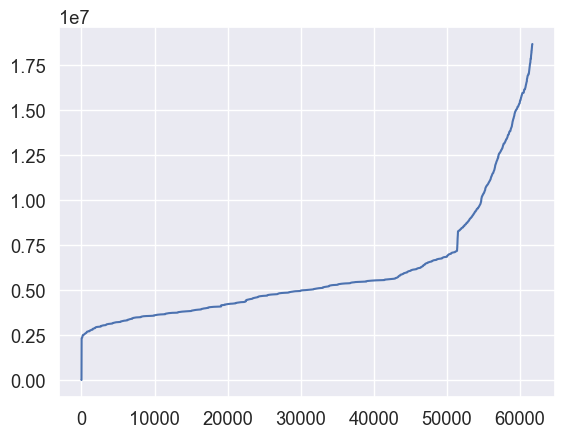

In [13]:
# Convert timestamps to timepoints
t_first = social_tij[0][0]
social_tij_pts = [(int((t - t_first).total_seconds()),i,j) for t,i,j in social_tij]
social_tij_pts[:10]

# Plot activity over time
plt.plot(np.arange(len(social_tij_pts)), np.array(social_tij_pts)[:,0])

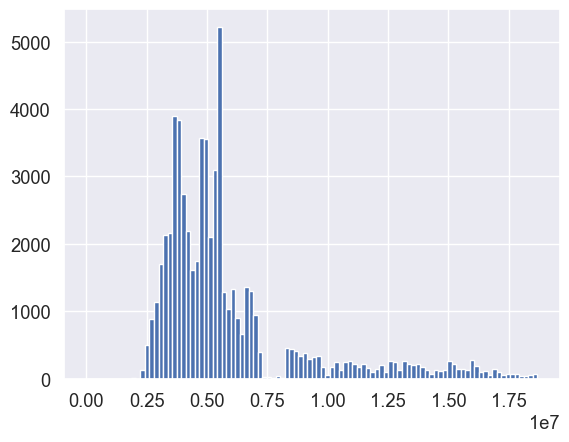

In [14]:
# Plot histogram of events over time
plt.hist(np.array(social_tij_pts)[:,0], bins=100);

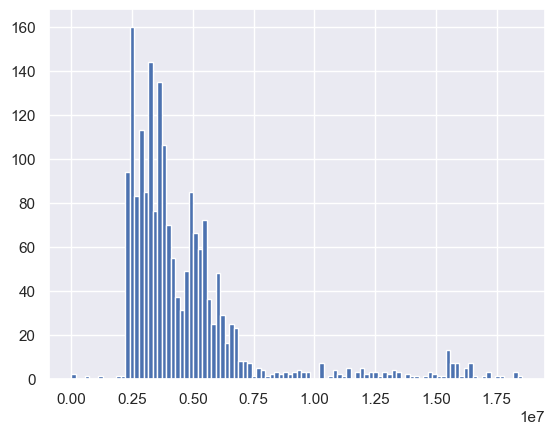

In [7]:
# Plot histogram of signups over time
social_tij_signups = np.array([(t,i,j) for t,i,j in social_tij_pts if i == j])
plt.hist(social_tij_signups[:,0], bins=100);

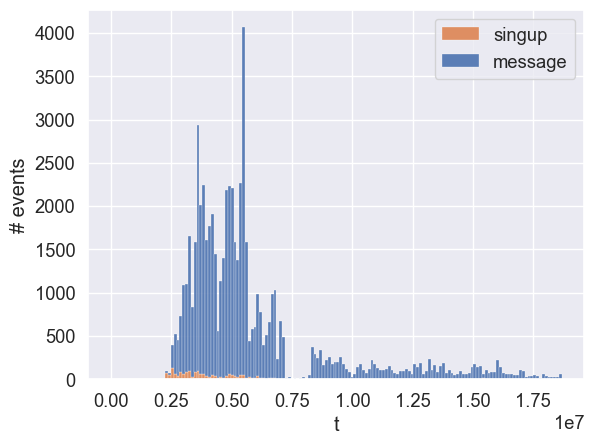

In [36]:
# Plot all activity (messages and signups) over time — used for report
data = pd.DataFrame(social_tij_pts, columns=['t', 'i', 'j'])
data['signup'] = data.apply(lambda row : row['i'] == row['j'], axis=1)

sns.histplot(data, x='t', hue='signup', multiple='stack', alpha=0.9)
plt.legend(labels=['singup', 'message'])
plt.ylabel('# events')

plt.savefig('./social_events.pdf', dpi=300)

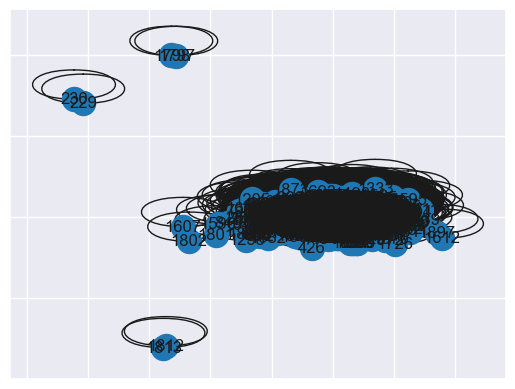

In [15]:
# Construct static graph
social_pts = nx.Graph()

people = [i for _,i,j in social_tij_pts if i==j]
social_pts.add_nodes_from(people)

for t, i, j in social_tij_pts :
    social_pts.add_edge(i, j)
    social_pts[i][j].setdefault('t', []).append(t)

nx.draw_networkx(social_pts)

In [11]:
# Save network to disk
nx.write_edgelist(social_pts, './networks/social_pts.txt')

## Mexican drugs

In [56]:
pd.read_csv('./data_sources/drugs/CosciaRios2012_DataBase.csv')

,Code,State,Year,Beltran_Leyva,Beltran_Leyva_Family,Familia,Golfo,Juarez,Sinaloa,Sinaloa_Family,Tijuana,Zetas,Otros
0,1001,1,1990,0,0,0,0,0,0,0,0,0,0
1,1001,1,1991,0,0,0,0,0,0,0,0,0,0
2,1001,1,1992,0,0,0,0,0,0,0,0,0,0
3,1001,1,1993,0,0,0,0,0,0,0,0,0,0
4,1001,1,1994,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51591,32058,32,2005,0,0,0,0,0,0,0,0,0,0
51592,32058,32,2006,0,0,0,0,0,0,0,0,0,0
51593,32058,32,2007,0,0,0,0,0,0,0,0,0,0
51594,32058,32,2008,0,0,0,0,0,0,0,0,0,0


## SCOTUS

In [55]:
pd.read_csv('./data_sources/scotus/dataverse_files/Indegmat.txt')

,caseid,1800,1801,1802,1803,1804,1805,1806,1807,1808,...,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30283,30284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
30284,30285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
30285,30286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
30286,30287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
with open('./data_sources/social/OCnodeslinks.txt', 'r') as f :
    social_tij = []
    for l in f.readlines() :
        t, i, j, _ = l.rsplit(maxsplit=3)
        t = datetime.datetime.strptime(t.strip("\""), '%Y-%m-%d %H:%M:%S')
        social_tij.append((t, int(i), int(j)))

social_tij[:10]